In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})



In [3]:
import examples.ice_melting.configs as cfg
from examples.ice_melting.model import PINN


cfg = cfg.Config()
pinn = PINN(config=cfg)
fnames = os.listdir(f"{cfg.DATA_PATH}/")
fnames = [fname for fname in fnames if "sol" in fname]
ts = [float(re.findall(r"\d+\.\d+", fname)[0]) for fname in fnames]
ts = jnp.array(ts)
ts = ts[ts<cfg.DOMAIN[-1][1] * cfg.Tc]

In [4]:
ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/tf-logs/ice-melting/irr/baseline-causal-4/model-4000/")
# state_noirr = ckpt.restore("/root/tf-logs/ice-melting/noirr/baseline-causal/model-2500/")
state_noirr = ckpt.restore("/root/tf-logs/ice-melting/noirr/baseline-3/model-4000/")
params = state["params"]
params_noirr = state_noirr["params"]

In [5]:
pred_radius = []
pred_radius_noirr = []
fem_radius = []
analytic_radius = []
skip_every = 1


def compute_radius(sol: jnp.ndarray):
    # interface_mask = (sol > -0.1) & (sol < 0.1)
    # selected_mesh = mesh[interface_mask]
    # return jnp.mean(jnp.linalg.norm(selected_mesh, axis=1)) * cfg.Lc
    volume_fraction = jnp.mean(jnp.where(sol > 0, 1, 0))
    # use the volume fraction to compute the radius
    r = (3 * volume_fraction / (4 * jnp.pi)) ** (1 / 3)
    return r * cfg.Lc

ts = jnp.arange(0, 5.1, 0.1)
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy")[::skip_every] / cfg.Lc
for idx, tic in enumerate(ts):
    t = jnp.ones_like(mesh[:, 0:1]) * tic / cfg.Tc
    pred = vmap(pinn.net_u, in_axes=(None, 0, 0))(params, mesh, t).squeeze()
    pred_noirr = vmap(pinn.net_u, in_axes=(None, 0, 0))(params_noirr, mesh, t).squeeze()
    Rt = cfg.R0 - cfg.LAMBDA * tic
    Rxyz = jnp.sqrt(mesh[:, 0] ** 2 + mesh[:, 1] ** 2 + mesh[:, 2] ** 2) * cfg.Lc
    ref_sol = jnp.tanh((Rt - Rxyz) / (jnp.sqrt(2) * cfg.EPSILON))
    diff = jnp.abs(pred - ref_sol)
    pred_radius.append(compute_radius(pred))
    pred_radius_noirr.append(compute_radius(pred_noirr))
    fem_radius.append(compute_radius(ref_sol))
    analytic_radius.append(cfg.R0 - cfg.LAMBDA * tic)

In [10]:
%matplotlib inline

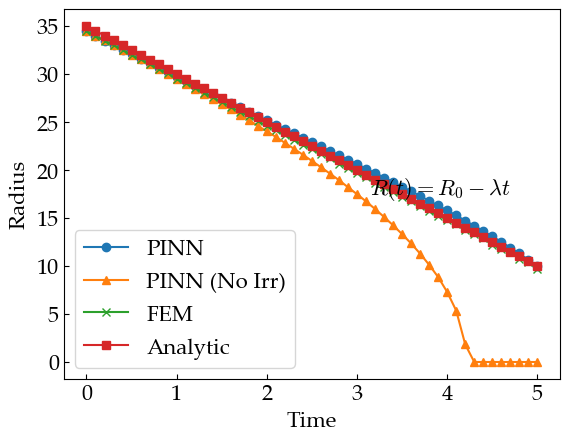

In [11]:

fig, ax = plt.subplots()
ax.plot(ts, pred_radius, label="PINN", marker="o")
ax.plot(ts, pred_radius_noirr, label="PINN (No Irr)", marker="^")
ax.plot(ts, fem_radius, label="FEM", marker="x")
ax.plot(ts, analytic_radius, label="Analytic", marker="s")

# put the formulation of the analytic solution
ax.text(0.9, 0.5, r"$R(t) = R_0 - \lambda t$", transform=ax.transAxes, ha="right")
ax.set_xlabel("Time")
ax.set_ylabel("Radius")

ax.legend()


In [12]:


def evaluate3D(pinn, params, mesh, ref_path, ts, **kwargs):
    fig = plt.figure(figsize=(3 * len(ts), 8))
    gs = GridSpec(4, len(ts) + 1, width_ratios=[0.1] + [1] * len(ts), height_ratios=[1, 1, 1, 0.3],
                  figure=fig)

    xlim = kwargs.get("xlim", (-0.5, 0.5))
    ylim = kwargs.get("ylim", (-0.5, 0.5))
    zlim = kwargs.get("zlim", (-0.5, 0.5))
    Lc = kwargs.get("Lc", 100)
    Tc = kwargs.get("Tc", 1.0)

    error = 0
    mesh /= Lc
    # mesh = mesh[::10]
    
    row_names = ["PINN", "FEM", "Error"]
    for idx, row_name in enumerate(row_names):
        ax = fig.add_subplot(gs[idx, 0])
        # put row name on the left vertical axis
        ax.text(0.5, 0.5, row_name, transform=ax.transAxes, 
                rotation=90, ha="center", va="center")
        ax.set_axis_off()

    for idx, tic in enumerate(ts):
        t = jnp.ones_like(mesh[:, 0:1]) * tic / Tc
        pred = vmap(pinn.net_u, in_axes=(None, 0, 0))(params, mesh, t).squeeze()

        ax = fig.add_subplot(gs[0, idx + 1], projection="3d", box_aspect=(1, 1, 1))
        interface_idx = (pred > -0.5) & (pred < 0.5)
        ax.scatter(
            mesh[interface_idx, 0],
            mesh[interface_idx, 1],
            mesh[interface_idx, 2],
            c=pred[interface_idx],
            cmap="coolwarm",
            label="phi",
            vmin=-1,
            vmax=1,
        )
        # r_pinn = (
        #     jnp.sqrt(
        #         mesh[interface_idx, 0] ** 2
        #         + mesh[interface_idx, 1] ** 2
        #         + mesh[interface_idx, 2] ** 2
        #     )
        #     * Lc
        # )
        r_pinn = compute_radius(pred)

        ax.set(
            xlabel="x",
            ylabel="y",
            zlabel="z",
            title=f"t={tic}",
            xlim=xlim,
            ylim=ylim,
            zlim=zlim,
        )
        ax.set_axis_off()
        ax.invert_zaxis()

        Rt = cfg.R0 - cfg.LAMBDA * tic
        Rxyz = jnp.sqrt(mesh[:, 0] ** 2 + mesh[:, 1] ** 2 + mesh[:, 2] ** 2) * Lc
        ref_sol = jnp.tanh((Rt - Rxyz) / (jnp.sqrt(2) * cfg.EPSILON))
        diff = jnp.abs(pred - ref_sol)

        ax = fig.add_subplot(gs[1, idx + 1], projection="3d", box_aspect=(1, 1, 1))
        interface_idx = (ref_sol > -0.5) & (ref_sol < 0.5)
        ax.scatter(
            mesh[interface_idx, 0],
            mesh[interface_idx, 1],
            mesh[interface_idx, 2],
            c=ref_sol[interface_idx],
            cmap="coolwarm",
            label="phi",
            vmin=-1,
            vmax=1,
        )
        ax.set(
            xlabel="x",
            ylabel="y",
            zlabel="z",
            xlim=xlim,
            ylim=ylim,
            zlim=zlim,
        )
        ax.set_axis_off()

        ax = fig.add_subplot(gs[2, idx + 1], projection="3d", box_aspect=(1, 1, 1))
        interface_idx = diff > 0.05
        error_bar = ax.scatter(
            mesh[interface_idx, 0],
            mesh[interface_idx, 1],
            mesh[interface_idx, 2],
            c=jnp.abs(pred[interface_idx] - ref_sol[interface_idx]),
            cmap="coolwarm",
            label="error",
        )

        ax.set(
            xlabel="x",
            ylabel="y",
            zlabel="z",
            xlim=xlim,
            ylim=ylim,
            zlim=zlim,
        )
        error += jnp.mean(diff**2)

        ax.set_axis_off()
        ax.invert_zaxis()

        interface_idx = jnp.where((ref_sol > -0.5) & (ref_sol < 0.5))[0]
        r_fem = compute_radius(ref_sol)
        # r_fem = (
        #     jnp.sqrt(
        #         mesh[interface_idx, 0] ** 2
        #         + mesh[interface_idx, 1] ** 2
        #         + mesh[interface_idx, 2] ** 2
        #     )
        #     * Lc
        # )
        r_analytical = cfg.R0 - cfg.LAMBDA * tic

        ax.text2D(
            0.05,
            -0.2,
            f"R_analytical = {r_analytical:.2f}\n"
            f"R_pinn = {jnp.mean(r_pinn):.2f}\n"
            f"R_fem = {jnp.mean(r_fem):.2f}",
            transform=ax.transAxes,
            ha="left",
            va="bottom",
        )
        
        ax = fig.add_subplot(gs[3, idx + 1])
        fig.colorbar(error_bar, ax=ax, orientation='horizontal')
        ax.set_axis_off()

    error /= len(ts)
    return fig, error

Text(0.5, 0.98, 'With Irreversible Constraint')

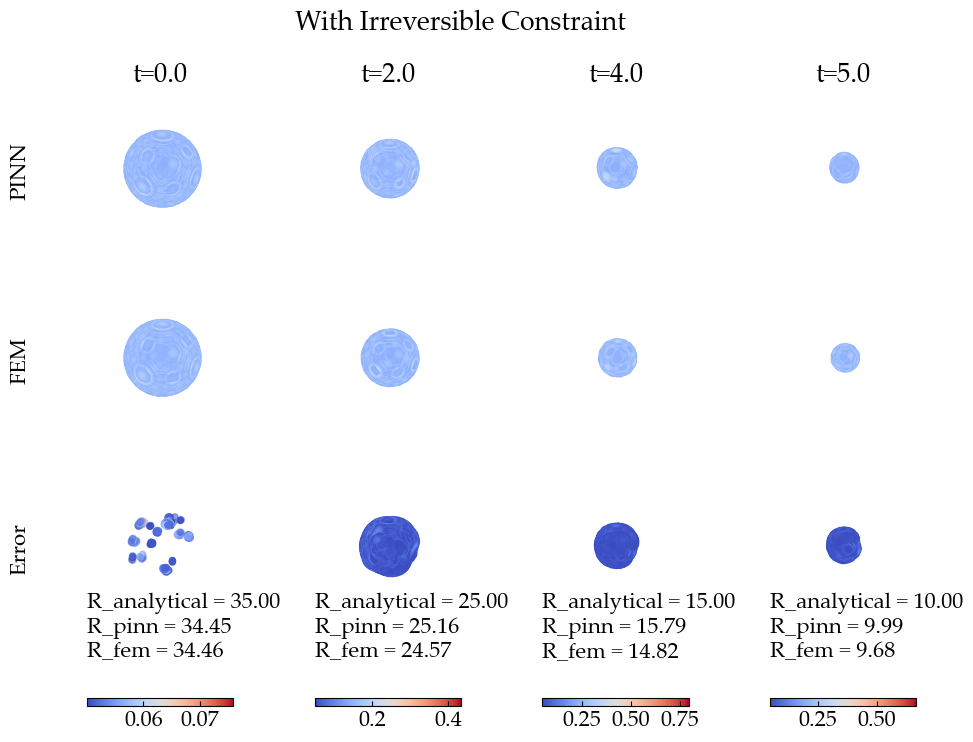

In [13]:
fig, error = evaluate3D(
            pinn,
            params,
            jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy"),
            cfg.DATA_PATH,
            ts=cfg.TS,
            Lc=cfg.Lc,
            Tc=cfg.Tc,
            xlim=cfg.DOMAIN[0],
            ylim=cfg.DOMAIN[1],
            zlim=cfg.DOMAIN[2],
        )
fig.suptitle(f"With Irreversible Constraint")

Text(0.5, 0.98, 'Without Irreversible Constraint')

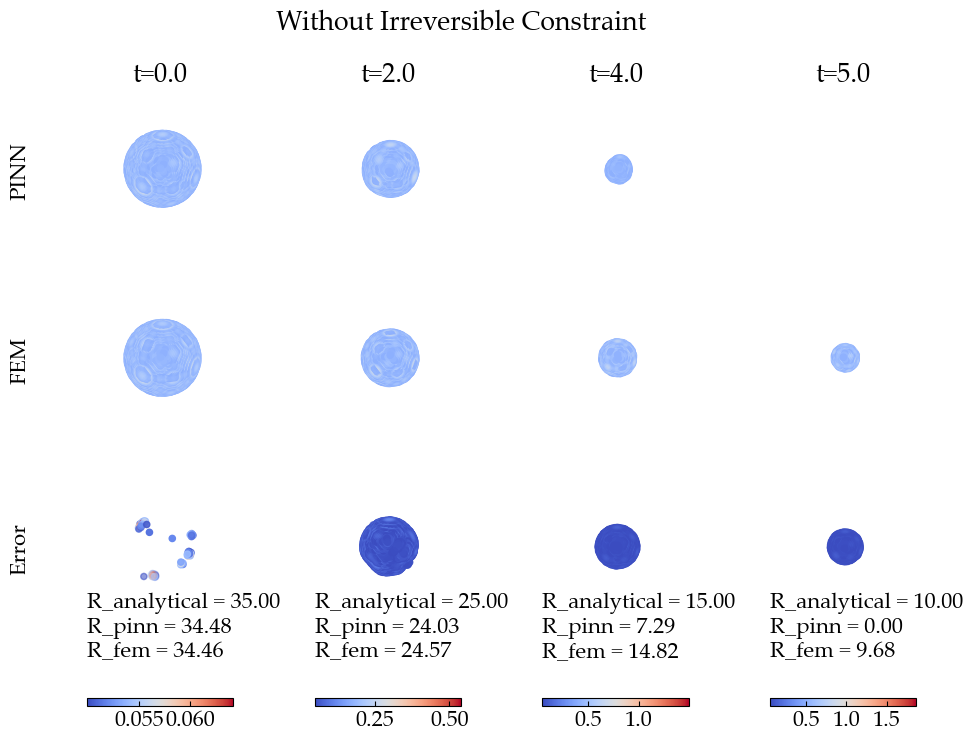

In [14]:
fig, error = evaluate3D(
            pinn,
            params_noirr,
            jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy"),
            cfg.DATA_PATH,
            ts=cfg.TS,
            Lc=cfg.Lc,
            Tc=cfg.Tc,
            xlim=cfg.DOMAIN[0],
            ylim=cfg.DOMAIN[1],
            zlim=cfg.DOMAIN[2],
        )
fig.suptitle(f"Without Irreversible Constraint")

In [11]:
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
params_noirr = ckpt.restore("/root/tf-logs/ice-melting/2025-03-17-20-40-04/model-1000/")["params"]


fig, axes = plt.subplots(1, 3, figsize=(10, 3), subplot_kw={"projection": "3d"})

for i, t in enumerate([2.5, 2.75, 3.0]):
    ax = axes[i]
    t = jnp.ones_like(mesh[:, 0:1]) * t / cfg.Tc
    dphi_dt = vmap(pinn.net_speed, in_axes=(None, 0, 0))(params_noirr, mesh, t)
    idx = jnp.where(dphi_dt > 0.0)[0]
    ax.scatter(mesh[idx, 0], mesh[idx, 1], mesh[idx, 2], c=dphi_dt[idx], cmap="coolwarm")
    # cb = plt.colorbar(ax.collections[0], ax=ax)


# refsol = jnp.load(f"{cfg.DATA_PATH}/sol-2.8000.npy")
# idx = jnp.where(refsol > 0.0)[0]
# ax.scatter(mesh[idx, 0], mesh[idx, 1], mesh[idx, 2])
# ax.set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5], zlim=[-0.5, 0.5])




FileNotFoundError: Checkpoint at /root/tf-logs/ice-melting/2025-03-17-20-40-04/model-1000 not found.

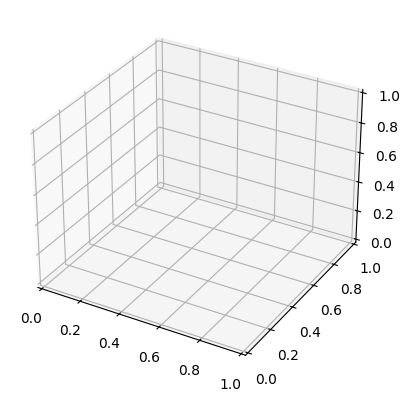

In [ ]:
mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
t = jnp.ones_like(mesh[:, 0:1]) * 3.0
dphi_dt = vmap(pinn.net_speed, in_axes=(None, 0, 0))(params, mesh, t)

idx = jnp.where(dphi_dt > 0.0)[0]
mesh = mesh[idx]
dphi_dt = dphi_dt[idx]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(mesh[:, 0], mesh[:, 1], mesh[:, 2], c=dphi_dt, cmap="coolwarm")


In [ ]:
vmap(pinn.net_speed, in_axes=(None, 0, 0))(params_noirr, mesh, t/cfg.Tc).max()

Array(-1.3173796e-05, dtype=float32)